In [1]:
!pip install sagemaker boto3 mxnet --quiet

In [160]:
import os
import sagemaker
import boto3
import mxnet as mx
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

iam = boto3.client('iam')
role = iam.get_role(RoleName='sagemaker-execution-role')['Role']['Arn']

In [87]:
def parse_time(event_time):
    hours, minutes = event_time.split(':')
    return 60*int(hours) + int(minutes)

class_mapping = {
    'explained': 0,
    'probable': 1,
    'unexplained': 2,
}

In [127]:
df = pd.read_csv('ufo_sightings.csv')
df['eventTime_minutes'] = df.apply(lambda x: parse_time(x.eventTime), axis=1)

df_continuous = df[['witnesses', 'latitude', 'longitude', 'duration', 'eventTime_minutes']]
df_continuous = df_continuous.apply(lambda col: (col-min(col))/(max(col)-min(col)))

df_categorical = df[['shape', 'weather', 'physicalEvidence', 'contact']]
df_categorical = pd.get_dummies(df_categorical)
df_categorical = df_categorical.drop(['physicalEvidence_N', 'contact_N'], axis=1)

df_label = df['researchOutcome'].map(lambda outcome: class_mapping[outcome])

df = pd.concat([df_label, df_continuous, df_categorical], axis=1)

In [146]:
data = df.values.astype('float32')
labels, features = data[:, 0], data[:, 1:]

np.random.seed(0)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)

In [153]:
model = sagemaker.LinearLearner(
    role=role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    predictor_type='multiclass_classifier',
    output_path=f's3://{bucket}/ufo_classifier/',
    num_classes=3,
)

train = model.record_set(train_features, train_labels, channel="train")
val = model.record_set(val_features, val_labels, channel="validation") # training stops when validation data shows overfitting
test = model.record_set(test_features, test_labels, channel="test")

model.fit([train, val, test])

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-07-09 05:32:53 Starting - Starting the training job...
2022-07-09 05:33:16 Starting - Preparing the instances for trainingProfilerReport-1657344772: InProgress
......
2022-07-09 05:34:19 Downloading - Downloading input data...
2022-07-09 05:34:56 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/09/2022 05:35:42 INFO 140282280281920] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_ins

[2022-07-09 05:35:47.310] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 14, "duration": 49, "num_examples": 2, "num_bytes": 244800}
#metrics {"StartTime": 1657344947.319359, "EndTime": 1657344947.3194396, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 4, "model": 0}, "Metrics": {"validation_multiclass_cross_entropy_objective": {"sum": 0.20836819966634115, "count": 1, "min": 0.20836819966634115, "max": 0.20836819966634115}}}
#metrics {"StartTime": 1657344947.3195395, "EndTime": 1657344947.3195627, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 4, "model": 1}, "Metrics": {"validation_multiclass_cross_entropy_objective": {"sum": 0.22674778408474391, "count": 1, "min": 0.22674778408474391, "max": 0.22674778408474391}}}
#metrics {"StartTime": 1657344947.3196194, "EndTime": 1657344947.3196368, "Dimensions": {"Algorithm": "Linear Learner", "Host": "


2022-07-09 05:35:57 Uploading - Uploading generated training model
2022-07-09 05:36:37 Completed - Training job completed
Training seconds: 107
Billable seconds: 107


In [163]:
label_map = {
    0: 'explained',
    1: 'probable',
    2: 'unexplained',
}

def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    batches = np.array_split(test_features, 100)
    prediction_batches = []
    print('Evaluating: ', end='')
    for i, batch in enumerate(batches):
        print('.', end='')
        prediction_batches += [predictor.predict(batch)]
    print()
        
    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label["predicted_label"].float32_tensor.values
    test_preds = np.concatenate(
        [np.array([extract_label(x) for x in batch]) for batch in prediction_batches]
    )
    test_preds = test_preds.reshape((-1,))

    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]

    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(
            test_preds == target_label, test_labels == target_label
        ).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({"recall": recall_per_class, "class_label": classes})
    recall.sort_values("class_label", ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(
        label_mapper(test_labels),
        label_mapper(test_preds),
        rownames=["Actuals"],
        colnames=["Predictions"],
        normalize="index",
    )

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="YlGnBu").set_title(
        "Confusion Matrix"
    )
    ax = recall.plot(
        kind="barh", x="class_label", y="recall", color="steelblue", title="Recall", legend=False
    )
    ax.set_ylabel("")
    print("Accuracy: {:.3f}".format(accuracy))

....................................................................................................
Accuracy: 0.944


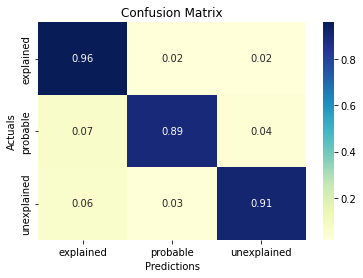

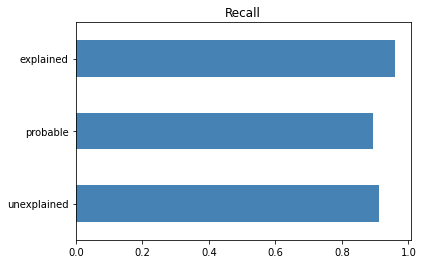

In [165]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
evaluate_metrics(predictor, test_features, test_labels)
predictor.delete_endpoint()